<a href="https://colab.research.google.com/github/lgvaz/projects/blob/master/vision/inpainting/pets_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = Path(root_dir + 'fastai-v3/')

Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from PIL import ImageDraw
from random import randint
from torchvision.models import resnet34, vgg16_bn

In [0]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/content/data/oxford-iiit-pet/images'),
 PosixPath('/content/data/oxford-iiit-pet/annotations')]

In [0]:
path_img = path/'images'

In [0]:
size = 64 * 4
bs = 6
size, bs

(256, 6)

In [0]:
src = ImageImageList.from_folder(path_img).split_by_rand_pct(0.1, seed=42)

In [0]:
class TfmPixelXOnly(TfmPixel):
    def __call__(self, *args, **kwargs):
        kwargs.pop('use_on_y', None)
        return super().__call__(*args, use_on_y=False, **kwargs)

In [0]:
def _draw_box(x):
    xy = x.shape[1:]
    bw, bh = randint(int(xy[0]*0.1), int(xy[0]*0.2)), randint(int(xy[1]*0.1), int(xy[1]*0.3))
    bx1, by1 = randint(0, xy[0]-bw), randint(0, xy[1]-bh)
    x[:, bx1:bx1+bh, by1:by1+bw] = 0
    return x

def _rand_boxes(x):
    for _ in range(randint(15, 20)): x = _draw_box(x)
    return x
rand_boxes = TfmPixelXOnly(_rand_boxes)

In [0]:
x_tfm, y_tfm = get_transforms(max_zoom=0.2)
y_tfm = x_tfm
x_tfm.append(rand_boxes())

In [0]:
data = (src
        .label_from_func(lambda x: x)
        .transform((x_tfm, x_tfm), tfm_y=True, size=size)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True)
       )

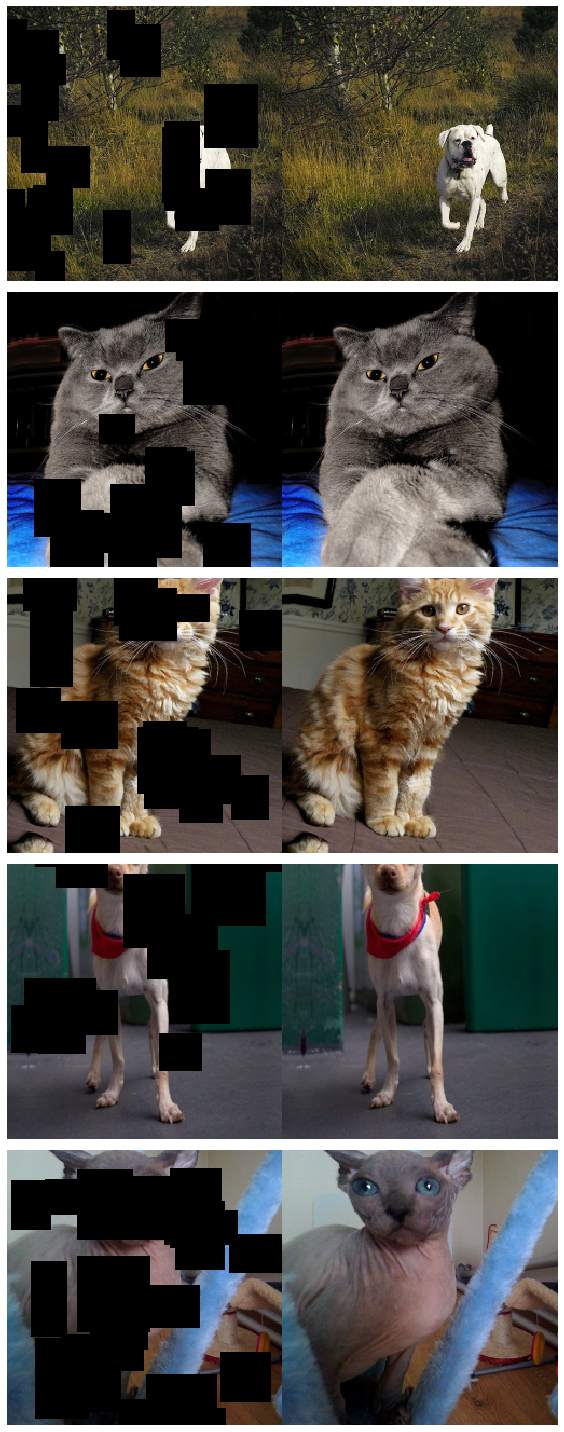

In [0]:
data.show_batch()

## Feature loss

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
base_loss = F.l1_loss

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layers, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layers))
              ] + [f'gram_{i}' for i in range(len(layers))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [0]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
layers = [vgg_m[i] for i in blocks]

In [0]:
feat_loss = FeatureLoss(vgg_m, layers=layers[2:5], layer_wgts=[5, 15, 2])

## Train

In [0]:
learn = None
gc.collect()

15170

In [0]:
learn = unet_learner(data, models.resnet50, wd=1e-3, loss_func=feat_loss,
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight,
                     self_attention=True).to_fp16()

In [0]:
learn.path = base_dir/'inpainting_pets/attention'

In [0]:
learn.load('res50-vgg-stage-2-128_3')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


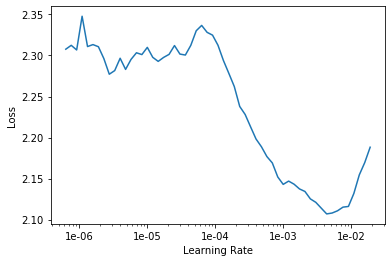

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
learn.freeze()
learn.fit_one_cycle(10, lr, pct_start=0.8)
learn.save('res50-vgg-stage-1-256_1')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.641234,1.589722,0.192643,0.162272,0.202229,0.127921,0.219175,0.375331,0.310152,22:45
1,1.589992,1.575200,0.197642,0.162318,0.200425,0.125619,0.213332,0.370221,0.305643,22:43
2,1.603863,1.620260,0.218297,0.165663,0.203189,0.126336,0.220572,0.380018,0.306185,22:43


In [0]:
learn.save('res50-vgg-stage-1-128')

In [0]:
learn.load('res50-vgg-stage-1-128')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


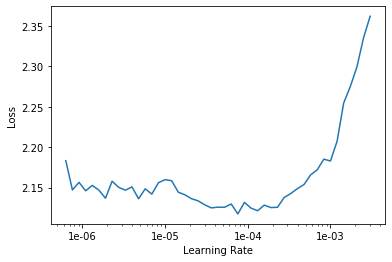

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(7, slice(1e-5, 1e-3), pct_start=0.3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.998421,1.958764,0.098507,0.104711,0.164262,0.130833,0.235765,0.603401,0.621284,05:12
1,2.085902,2.108834,0.112490,0.113149,0.177899,0.140674,0.251989,0.649589,0.663043,05:11
2,2.054880,2.078129,0.114585,0.111076,0.175202,0.138667,0.247202,0.633357,0.658039,05:11
3,2.042886,2.005546,0.097352,0.105978,0.166219,0.135746,0.237856,0.611361,0.651034,05:12
4,1.976170,1.994097,0.097364,0.105851,0.166953,0.133734,0.236829,0.616329,0.637039,05:12
5,1.928973,1.936380,0.094014,0.101544,0.160697,0.131561,0.227904,0.594714,0.625947,05:12
6,1.947899,1.886156,0.090172,0.099759,0.157371,0.126914,0.225041,0.582130,0.604769,05:12


In [0]:
learn.save('res50-vgg-stage-2-128_3')

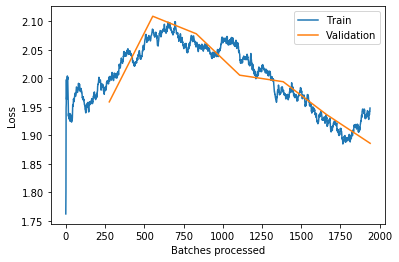

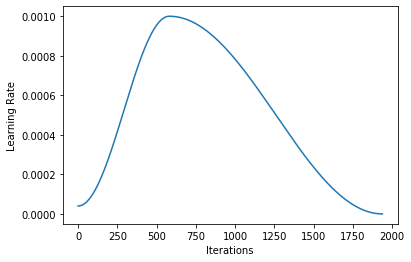

In [0]:
learn.recorder.plot_losses(); learn.recorder.plot_lr()

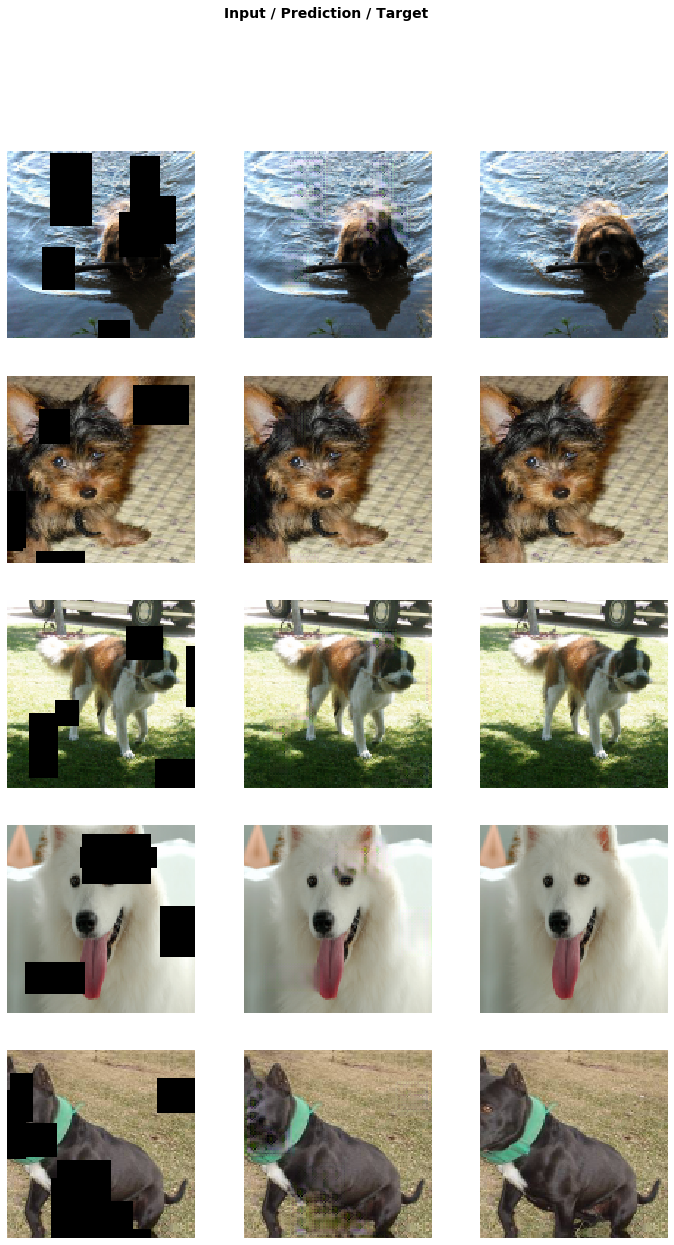

In [0]:
learn.show_results(ds_type=DatasetType.Valid)

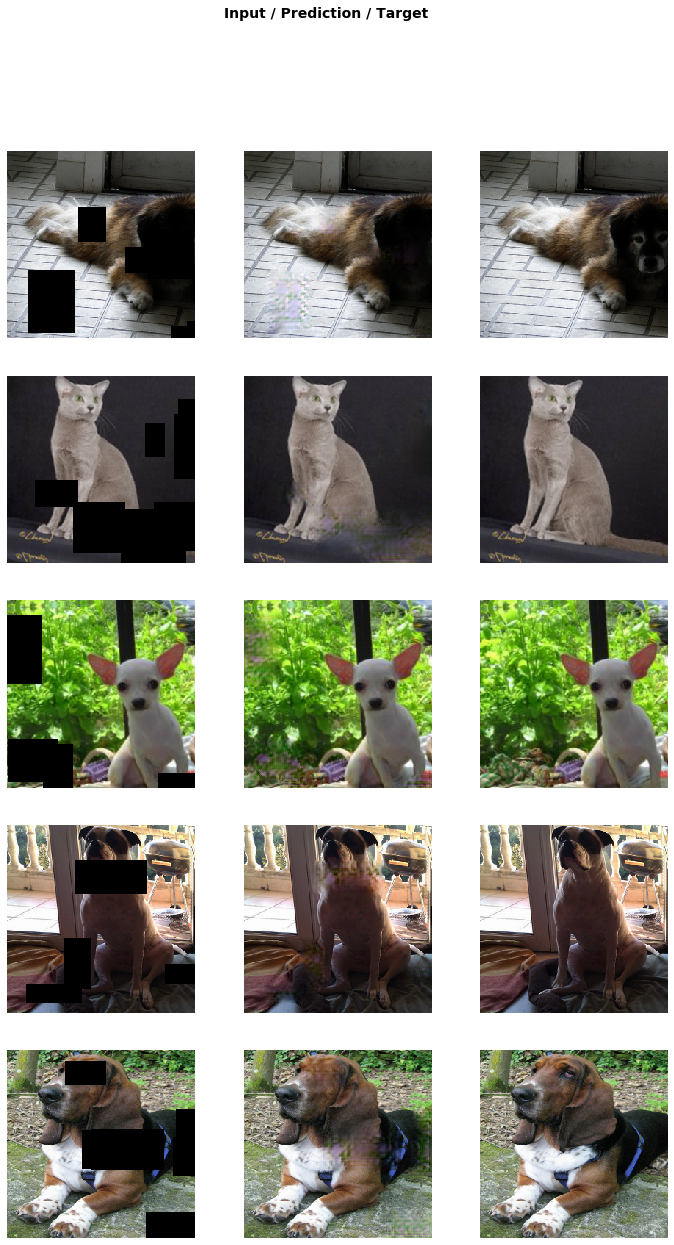

In [0]:
learn.show_results(ds_type=DatasetType.Train)